# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 6: Logistic Regression 

**Harvard University**<br>
**Fall 2019**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras.  <br>
**Contributors:** Chris Tanner

---

In [197]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals (EDIT)
In this lab, we'll explore different models used to predict which of several labels applies to a new datapoint based on labels observed in the training data.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Linear Regression
 - Logistic Regression
- Be able to make an informed choice of model based on the data at hand
- (Bonus) Structure your sklearn code into Pipelines to make building, fitting, and tracking your models easier
- (Bonus) Apply weights to each class in the model to achieve your desired tradeoffs between discovery and false alarm in various classes

In [198]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split

## Part 1:  The AirBnB NYC 2019 Dataset + EDA
The dataset contains information about AirBnB hosts in NYC from 2019. There are 49k unique hosts and 16 features for each:

- **id:** listing ID
- **name:** name of the listing
- **host_id:** host ID
- **host_name:** name of the host
- **neighbourhood_group:** NYC borough
- **neighbourhood:** neighborhood
- **latitude:** latitude coordinates
- **longitude:** longitude coordinates
- **room_type:** listing space type (e.g., private room, entire home)
- **price:** price in dollars per night
- **minimum_nights:** number of min. nights required for booking
- **number_of_reviews:** number of reviews
- **last_review:** date of the last review
- **reviews_per_month:** number of reviews per month
- **calculated_host_listings_count:** number of listings the host has
- **availability_365:** number of days the listing is available for booking

Our goal is to predict the price of unseen housing units as being 'affordable' or 'unaffordable', by using their features. We will assume that this task is for a particular client who has a specific budget and would like to simplify the problem by classifying any unit that costs \< \\$150 per night as 'affordable' and any unit that costs \\$150 or great as 'unaffordable'.

For this task, we will exercise our normal data science pipeline -- from EDA to modelling and visualization. In particular, we will show the performance of 3 classifiers:

- Maximum Likelihood Estimate (MLE)
- Linear Regression
- Logistic Regression

Let's get started! And awaaaaay we go!

### Read-in and checking
We do the usual read-in and verification of the data:

In [199]:
df = pd.read_csv("../data/nyc_airbnb.csv") #, index_col=0)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Building the training/dev/testing data
As usual, we split the data before we begin our analysis. It would be unfair to cheat by looking at the testing data. Let's divide the data into 60% training, 20% development (aka validation), 20% testing. However, before we split the data, let's make the simple transformation and converting the prices into a categories of being _affordable_ or not.

In [200]:
df['affordable'] = np.where(df['price'] < 150, 1, 0)
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,affordable
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,0
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0,1
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220,1
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0,1
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188,0


**NOTE:** The `affordable` column now has a value of 1 whenever the price is < 150, and 0 otherwise.

Also, the feature named `neighbourhood_group` can be easily confused with `neighbourhood`, so let's go ahead and rename it to `borough`, as that is more distinct:

In [201]:
df.rename(columns={"neighbourhood_group": "borough"}, inplace=True)
df

,id,name,host_id,host_name,borough,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,affordable
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,0
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0,1
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220,1
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0,1
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188,0


Without looking at the full data yet, let's just ensure our prices are within valid ranges:

In [202]:
df['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Uh-oh. We see that `price` has a minimum value of \\$0. I highly doubt any unit in NYC is free. These data instances are garbage, so let's go ahead and remove any instance that has a price of \\$0.

In [203]:
print("original training size:", df.shape)
df = df.loc[df['price'] != 0]
print("new training size:", df.shape)

original training size: (48895, 17)
new training size: (48884, 17)


Now, let's split the data while ensuring that our test set has a fair distribution of affordable units, then further split our training set so as to create the development set:

In [204]:
#stratify by affordable category for train and test category
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['affordable'])
#no stratification for train, val(dev) split?
df_train, df_dev = train_test_split(df_train, test_size=0.25, random_state=99) #stratify=df_train['affordable'])

# ensure our dataset splits are of the % sizes we want
total_size = len(df_train) + len(df_dev) + len(df_test)
print("train:", len(df_train), "=>", len(df_train) / total_size)
print("dev:", len(df_dev), " =>", len(df_dev) / total_size)
print("test:", len(df_test), "=>", len(df_test) / total_size)

train: 29330 => 0.5999918173635546
dev: 9777  => 0.20000409131822272
test: 9777 => 0.20000409131822272


Let's remove the target value (i.e., __affordable__) from our current dataframes and create it as separate prediction dataframes.

In [205]:
# training
x_train = df_train.drop(['price', 'affordable'], axis=1)
y_train = pd.DataFrame(data=df_train['affordable'], columns=["affordable"])

# dev
x_dev = df_dev.drop(['price', 'affordable'], axis=1)
y_dev = pd.DataFrame(data=df_dev['affordable'], columns=["affordable"])

# test
x_test = df_test.drop(['price', 'affordable'], axis=1)
y_test = pd.DataFrame(data=df_test['affordable'], columns=["affordable"])

From now onwards, we will do EDA and cleaning based on the training set, `x_train`.

In [206]:
for col in x_train.columns:
    print(col, ":", np.sum([x_train[col].isnull()]))

id : 0
name : 12
host_id : 0
host_name : 12
borough : 0
neighbourhood : 0
latitude : 0
longitude : 0
room_type : 0
minimum_nights : 0
number_of_reviews : 0
last_review : 6065
reviews_per_month : 6065
calculated_host_listings_count : 0
availability_365 : 0


Oh dear. It appears ~6k of the rows have missing values concerning the reviews. It seems impossible to impute the `last_review` feature with reasonable values, as this is very specific to each unit. At best, we could guess the date based on the `reviews_per_month`, but that feature is missing for the same rows. Further, it might be difficult to replace `reviews_per_month` with reasonable values -- sure, we could fill in values to be the median value, but that seems wrong to generalize so heavily, especially for over 20% of our data. Consequently, let's just ignore these two columns.

In [207]:
x_train = x_train.drop(['last_review', 'reviews_per_month'], axis=1)

Let's look at the summary statistics of the data:

In [208]:
x_train.describe()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,2.933000e+04,2.933000e+04,29330.000000,29330.000000,29330.000000,29330.000000,29330.000000,29330.000000
mean,1.899091e+07,6.746725e+07,40.729049,-73.952129,6.891647,23.490829,7.111081,113.047017
std,1.102972e+07,7.863754e+07,0.054446,0.046320,19.236816,45.324235,32.904893,131.845296
min,2.539000e+03,2.438000e+03,40.499790,-74.242850,1.000000,0.000000,1.000000,0.000000
25%,9.380684e+06,7.794212e+06,40.690423,-73.983130,1.000000,1.000000,1.000000,0.000000
50%,1.960499e+07,3.049924e+07,40.723090,-73.955630,3.000000,5.000000,1.000000,44.000000
75%,2.921518e+07,1.074344e+08,40.763067,-73.936100,5.000000,24.000000,2.000000,228.000000
max,3.648561e+07,2.743213e+08,40.913060,-73.712990,1000.000000,629.000000,327.000000,365.000000


Next, we see that the `minimum_nights` feature has a maximum value of 1,250. That's almost 3.5 years, which is probably longer than the duration that most people rent an apartment. This seems anomalous and wrong. Let's discard it and other units that are outrageous. Well, what constitutes 'outrageous'? We see that the standard deviation for `minimum_nights` is 21.24. If we assume our distribution of values are normally distributed, then only using values that are within 2 standard deviations of the mean would yield us with ~95% of the original data. However, we have no reason to believe our data is actually normally distributed, especially since our mean is 7. To have a better idea of our actual values, let's plot it as a histogram.

Text(0, 0.5, 'count')

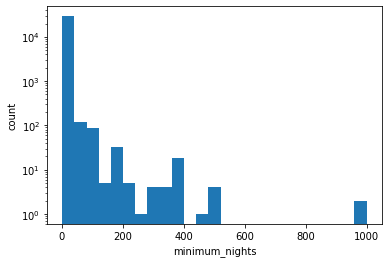

In [209]:
fig, ax = plt.subplots(1,1)
ax.hist(x_train['minimum_nights'], 25, log=True)
plt.xlabel('minimum_nights')
plt.ylabel('count')

Yea, that instance was a strong outlier, and the host was being ridiculously greedy. That's a clever way to get out a multi-year lease. Notice that we are using log-scale. Clearly, a lot of our mass is from units less than 365 days. To get a better sense of that subset, let's re-plot only units with minumum_nights < 365 days.

Text(0, 0.5, 'count')

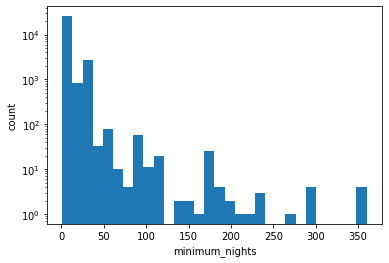

In [210]:
subset = x_train['minimum_nights']<365
fig, ax = plt.subplots(1,1)
ax.hist(x_train['minimum_nights'][subset], 30, log=True)
plt.xlabel('minimum_nights')
plt.ylabel('count')

Ok, that doesn't look too bad, as most units require < 30 nights. It's surprising that some hosts list an unreasonable requirement for the minimum number of nights. There is a risk that any host that lists such an unreasonable value might also have other incorrect information. Personally, I think anything beyond 30 days could be suspicious. If we were to exclude any unit that requires more than 30 days, how many instances would we be ignoring?

In [211]:
len(x_train.loc[x_train['minimum_nights']>30])

436

Alright, we'd be throwing away 436 out of our ~30k entries. That's roughly 1.5\% of our data. While we generally want to keep and use as much data as we can, I think this is an okay amount to discard, especially considering (1) we have a decently large amount of data remaining, and (2) the entries beyond a 30-day-min could be unrealiable.

In [212]:
good_subset = x_train['minimum_nights'] <= 30
x_train = x_train.loc[good_subset]
y_train = y_train.loc[good_subset]

The remaining columns all have reasonable summary statistics. None of the min's or max's are cause for concern, and we have no reason to assert a certain distribution of values. Since all the feature values are within reasonable ranges, and there are no missing values (NaNs) remaining, we can confidently move foward. To recap, our remaining columns are now:

In [213]:
[col for col in x_train.columns] # easier to read vertically than horizontally

['id',
 'name',
 'host_id',
 'host_name',
 'borough',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'calculated_host_listings_count',
 'availability_365']

We don't have a terribly large number of features. This allows us to inspect every pairwise interaction. A scatterplot is great for this, as it provides us with a high-level picture of how every pair of features correlates. If any subplot of features depicts a linear relationship (i.e., a clear, concise path with mass concentrated together), then we can assume there exists some collinearity -- that the two features overlap in what they are capturing and that they are not independent from each other.

In [214]:
#scatter_matrix(x_train, figsize=(30,20));

## Part 2:  Predicting with MLE

Maximum-likelihood estimation (MLE) is a very simple model which does not require _learning_ any weight/coefficient parameters. Specifically, MLE selects the parameter value ($y$) that makes the observed data most probable, so as to maximize the likelihood function. This choice of $y$ is completely independent of $x$. That is, a MLE model returns the $y$-value that was probable in the data its seen.

<br>
<div class="exercise"><b>Exercise 1:</b> Using the training data, select the MLE for $y$, where $y \in \{0,1\}$. Using the development to evaluate your MLE model, what is the accuracy (the % correct)?</div>

In [215]:
# [SOLUTION: REMOVE]
mle_train = np.mean(y_train['affordable']) #mle model is just the fraction of 1s
mle_dev = np.mean(y_dev['affordable'])
mle_dev

0.650301728546589

In [216]:
x_train['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

## Part 3:  Predicting with Linear Regression

Now, let's actually use our features to make more informed predictions. Since our model needs to use numeric values, not textual ones, let's use **ONLY** the following features for our linear model:

- `borough`, using 1-hot encodings. There are 5 distinct boroughs, so represent them via 4 unique columns.
- `latitude`
- `longitude`
- `room_type`, using 1-hot encodings. There are 3 distinct room_types, so represent them via 2 unique columns.
- `minimum_nights`
- `number_of_reviews`
- `calculated_host_listings_count`
- `availability_365`

<br>
<div class="exercise"><b>Exercise 2:</b> Convert `x_train` to have only the columns listed above. The shape should be 28,894 x 12 </div>

In [217]:
# [SOLUTION: remove!!]
x_train = x_train.drop(columns = ['id','name','host_id','host_name','neighbourhood'])
x_train = pd.get_dummies(x_train, columns = ['borough','room_type'], drop_first=True)
x_train.shape

(28894, 12)

<div class="exercise"><b>Exercise 3:</b> For this exercise, perform multi-linear regression and evaluate it on the development set. Do not introduce any polynomial terms or any other new features. Any prediction that is >= 0.5 should be treated as being an 'affordable' prediction. Anything below 0.5 should be 'unaffordable'. What is your accuracy %? (). Is this what you expected? Is this reasonable, and if not, what do you think are the issues?</div>

In [218]:
# [SOLUTION HERE]
x_dev = x_dev.drop(columns = ['id','name','host_id','host_name','neighbourhood','last_review','reviews_per_month'])
x_dev = pd.get_dummies(x_dev, columns = ['borough','room_type'], drop_first=True)

In [219]:
good_subset = x_dev['minimum_nights'] <= 30
x_dev = x_dev.loc[good_subset]
y_dev = y_dev.loc[good_subset]

In [220]:
from sklearn.linear_model import LinearRegression

OLSmodel = LinearRegression().fit(x_train, y_train['affordable'])
y_pred = OLSmodel.predict(x_dev)
np.mean((y_pred >= 0.5) == y_dev['affordable'])

0.7789331392326089

<div class="exercise"><b>Exercise 4:</b> Akin to what you did in Homework 3, regularize your model via Ridge regression and Lasso regression. Specifically, report the model's accuracy on the development set (as you did in Exercise 2); do so while varying the alpha (aka lambda) parameter to be each of these values: [.01, .05, .1, .5, 1, 5, 10, 50, 100]). What is your best result?</div>

In [221]:
# [SOLUTION HERE]


<div class="exercise"><b>Exercise 5:</b> Plot the residuals of your best performing linear regression model. Does it adhere to the assumptions of a linear model?</div>

In [222]:
# [SOLUTION HERE]

## Part 4: Binary Logistic Regression
Linear regression is usually a good baseline model, but since the outcome we're trying to predict only takes values 0 and 1 we'll want to use logistic regression instead of basic linear regression.

We will use `sklearn` for now, but `statsmodels` also provides LogisticRegression, along with nifty features like confidence intervals.

First, let's import the necessary classes:

In [223]:
from sklearn.linear_model import LogisticRegression


Next, let's instantiate a new LogisticRegression model:

In [235]:
lr = LogisticRegression()

Now, we can fit our model with just 1 line!

In [236]:
#x_train
lr.fit(x_train, y_train['affordable'])

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

<div class="exercise"><b>Exercise 6:</b> Using .predict(), make predictions on the development set </div>


In [237]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(x_dev)
accuracy_score(y_dev['affordable'], y_pred)

0.7758136633045648

In [238]:
#by default, it regularizes coef! you need to change C (or penalty/solver)
lr = LogisticRegression(C=0.1, penalty='l1', max_iter=200)
lr.fit(x_train, y_train['affordable'])
y_pred = lr.predict(x_dev)
accuracy_score(y_dev['affordable'], y_pred)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7818446500987835

See [.predict()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) documentation here. **NOTE:** regularization is applied by default. See the **penality** argument for details! Note the **C** penalty, which we discussed in class. Experiment with varying values from 0 to 100 million! Also, the **max_iterations** should be varied from 5 to 500. Do you expect more iterations to always perform better? Why or why not?

After fitting the model, you can print the ``.coef_`` value to see its coefficient.

<div class="exercise"><b>Exercise 7:</b> Accuracy is only one measure that we may be interested in. For example, maybe the cost of making some mistakes are greater than making others (e.g., if we were predicting cancer). For this, let's turn to what we learned in class about false positives and false negatives. Namely, for this exercise, construct an ROC curve, where the true negatives are on the x-axis and true positives are on the y-axis. What is the ideal shape that we wish to have?</div>


## Part 5 (The Real Challenge): Multiclass Classification
Before we move on, let's consider a more common use case of logistic regression: predicting not just a binary variable, but what level a categorical variable will take. Instead of breaking the price variable into two classes (affordable being true or false), we may care for more fine-level granularity.

For this exercise, go back to the original `df` dataframe and construct 5 classes of pricing:

- budget: < 80
- affordable: 80 < x < 119
- average: 120 < x < 179
- expensive: 180 < x < 239
- very expensive: 240 < x

The `cut` function obviously stores a lot of extra information for us. It's a very useful tool for discretizing an existing variable.

<div class="exercise"><b>Exercise 8:</b> After making the new categories, perform the same predictions as above. Compare your results. What improvements could we make? (not just w/ the parameters, but with possibly expanding and using other features from our original dataset!)</div>
